In [1]:
# parameters used
FLIP_FLAG        = True    # if True adds flipped images for training
CROP_FLAG        = True    # if True cropps undesired portions of an image
NORM_FLAG        = True    # if True normalizes the input to network
RL_IM_FLAG       = True    # if True uses the left and right images as well

IMAGE_SHAPE      = (160, 320, 3)
TOP_CROP         = 62      # where to crop at top of image
BOTTOM_CROP      = 24      # where to crop at bottom of image
CAMERA_DELTA     = 0.002   # distance between cameras, assuming vertical distance is normalized 1
PROB_LR          = 0.6     # probability of using a left/right image
SAVED_FN         = "model.h5"
EPOCHS           = 3
BATCH_SIZE       = 64
VALIDATION_SPLIT = 0.25
KP               = 0.3     # keep prob

# NVIDIA Network config: K=kernel, F=features, S=stride
K = [5,  5,  5,  3,  3]
F = [24, 36, 48, 64, 64]
S = [2,   2,  2,  1,  1]
FC= [100, 50, 10]

In [2]:
# imports
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from IPython.display import Image, display, SVG

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.utils.visualize_util import model_to_dot
from keras.utils.visualize_util import plot

%matplotlib inline

Using TensorFlow backend.


In [3]:
# read csv file to a list caled "lines"
lines =[]
with open("data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    i=0  # ended up using portion of training set
    for _line in reader:
        if (i<9767):
            lines.append(_line)
        i +=1
image_size = len(lines)
print("Captured {} 'center' images".format(image_size))

Captured 9767 'center' images


In [4]:
# reads an image file
def get_image(fn):
    _im = cv2.imread(fn)
    _im = cv2.cvtColor(_im, cv2.COLOR_BGR2RGB)
    assert _im.shape == IMAGE_SHAPE
    return(_im)

# list of lines --> images, measurments
measurements = []  # steering measurments
images       = []  # list, so that can append

for _line in lines:
    _im = get_image(_line[0])   
    images.append(_im)
    _measure = float(_line[3])
    measurements.append(_measure)
    if (FLIP_FLAG == True):
        images.append(np.fliplr(_im))
        measurements.append(-_measure)

In [5]:
# use left and right captured images as well
if (RL_IM_FLAG == True):
    for _line in lines:
        # measurement is converted to distance
        _delta     = np.arctan((np.pi/180) * float(_line[3]))
        # _delta is combined with CAMERA_DELTA to generate new measurements
        _theta_l   = (180/np.pi)*np.tan(_delta + CAMERA_DELTA)
        _theta_r   = (180/np.pi)*np.tan(_delta - CAMERA_DELTA)
    
        # left image
        if (random.random() < PROB_LR):
            _im = get_image(_line[1]) 
            images.append(_im)
            measurements.append(_theta_l)
        #if (FLIP_FLAG == True):
        #    images.append(np.fliplr(_im))
        #    measurements.append(-_theta_l)
    
        # right image
        if (random.random() < PROB_LR):
            _im = get_image(_line[2]) 
            images.append(_im)
            measurements.append(_theta_r)
        #if (FLIP_FLAG == True):
        #    images.append(np.fliplr(_im))
        #    measurements.append(-_theta_r)

In [6]:
# images, measurments --> numpy
X_train = np.array(images)
y_train = np.array(measurements)
print("X_train:")
print("   shape = {}".format(X_train.shape))
print("   type = {}".format(X_train.dtype))
print("   size = {} bytes".format(np.prod(X_train.shape)))
print("y_train shape = {}".format(y_train.shape))

X_train:
   shape = (31287, 160, 320, 3)
   type = uint8
   size = 4805683200 bytes
y_train shape = (31287,)


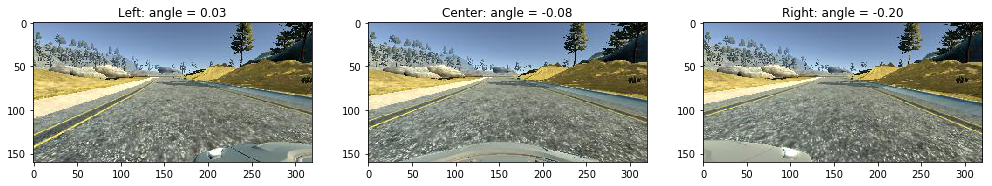

In [7]:
# LEFT RIGHT IMAGES LAB: to decide what CAMERA_DELTA to use
_index = random.randint(0, len(lines))
_line = lines[_index]
_im_c  = get_image(_line[0])
_im_l  = get_image(_line[1])
_im_r  = get_image(_line[2])

# measurement is converted to distance
_theta_c   = float(_line[3])
_delta     = np.arctan((np.pi/180) * _theta_c)
# _delta is combined with CAMERA_DELTA to generate new measurements
_theta_l   = (180/np.pi)*np.tan(_delta + CAMERA_DELTA)
_theta_r   = (180/np.pi)*np.tan(_delta - CAMERA_DELTA)

plt.figure(figsize=(17,7))
plt.subplot(1,3,1)
plt.imshow(np.uint8(_im_l))
plt.title("Left: angle = {:.2f}".format(_theta_l))

plt.subplot(1,3,2)
plt.imshow(np.uint8(_im_c))
plt.title("Center: angle = {:.2f}".format(_theta_c))

plt.subplot(1,3,3)
plt.imshow(np.uint8(_im_r))
plt.title("Right: angle = {:.2f}".format(_theta_r))
_ =plt.show

In [8]:
# This cell is from project 1: it masks an image given coordinates

# from mask offsets to mask vertices
def get_vertices(img,offsets):
    image_size = img.shape
    vertices = np.zeros_like(offsets)
    vertices[0,0,0] = offsets[0,0,0]
    vertices[0,0,1] = image_size[0]-offsets[0,0,1]
    vertices[0,1,0] = offsets[0,1,0]
    vertices[0,1,1] = offsets[0,1,1]
    vertices[0,2,0] = image_size[1] - offsets[0,2,0]
    vertices[0,2,1] = offsets[0,2,1]
    vertices[0,3,0] = image_size[1] - offsets[0,3,0]
    vertices[0,3,1] = image_size[0] - offsets[0,3,1]
    return(vertices)

 # Applies an image mask.
def region_of_interest(_img, vertices):
    # initialize mask
    mask = np.zeros_like(_img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    channel_count = _img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,) * channel_count
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_im = cv2.bitwise_and(_img, mask)
    return(masked_im)

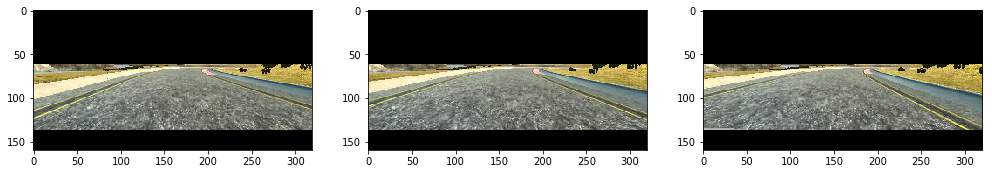

In [9]:
# MASK LAB: to decide where to mask
mask_offsets_b = np.array([[(0,BOTTOM_CROP),(0,0),(0,0),(0,BOTTOM_CROP)]])
mask_offsets_t = np.array([[(0,0),(0,TOP_CROP ),(0,TOP_CROP ),(0,0)]])

_index = random.randint(0, len(lines))
_line = lines[_index]
_im_c  = get_image(_line[0])
_im_l  = get_image(_line[1])
_im_r  = get_image(_line[2])

vertices_b  = get_vertices(_im_c,mask_offsets_b)
vertices_t  = get_vertices(_im_c,mask_offsets_t)
_masked_im  = region_of_interest(_im_c, vertices_b)
_masked_im_c  = region_of_interest(_masked_im, vertices_t)

_masked_im  = region_of_interest(_im_l, vertices_b)
_masked_im_l  = region_of_interest(_masked_im, vertices_t)

_masked_im  = region_of_interest(_im_r, vertices_b)
_masked_im_r  = region_of_interest(_masked_im, vertices_t)

plt.figure(figsize=(17,7))
plt.subplot(1,3,1)
plt.imshow(np.uint8(_masked_im_l))

plt.subplot(1,3,2)
plt.imshow(np.uint8(_masked_im_c))

plt.subplot(1,3,3)
plt.imshow(np.uint8(_masked_im_r))
_ =plt.show

In [10]:
# add conv layer
def add_conv_layer(k,f,s,model):
    model.add(Convolution2D(f,k,k,activation='relu'))
    model.add(MaxPooling2D((s,s)))
    return(model)

# add fc layer
def add_fc_layer(n,kp,model):
    model.add(Dense(n))   
    model.add(Dropout(kp))
    return(model)

In [11]:
# network model from keras
model = Sequential()

# normalize input?
if(NORM_FLAG == True):
    model.add(Lambda(lambda x: (x/255.) - 0.5, input_shape=IMAGE_SHAPE))

# crop?
if(CROP_FLAG == True):
    model.add(Cropping2D(cropping=((TOP_CROP,BOTTOM_CROP), (0,0)), input_shape=IMAGE_SHAPE))
    
assert len(K) == len(F)
assert len(K) == len(S)

# conv + pooling
for i in range(len(S)):
    model = add_conv_layer(K[i],F[i],S[i],model)  

model.add(Flatten())
units = model.output_shape[1]

# FC
for i in range(len(FC)):
    model = add_fc_layer(FC[i],KP,model)
model.add(Dense(1))      # steering angle

In [12]:
# network complexity (trainable parameters)
def get_conv_complexity(k,f_in,f_out):
    return(k*k*f_in*(f_out+1))

def get_fc_complexity(_in,_out):
    return(_in*(_out+1))

l = []
_l = get_conv_complexity(K[0],3,F[0])
l.append(_l)
print(" Conv layer {} complexity = {}".format(1,_l))
for i in range(len(K)-1):
    _l = get_conv_complexity(K[i+1],F[i],F[i+1])
    print(" Conv layer {} complexity = {}".format(i+2,_l))
    l.append(_l)
l_c = np.sum(l)
print("Conv complexity = {}".format(l_c))

l = []
_l = (get_fc_complexity(units,FC[0]))
l.append(_l)
print(" FC layer {} complexity = {}".format(1,_l))
for i in range(len(FC)-1):
    _l = get_fc_complexity(FC[i],FC[i+1])
    print(" FC layer {} complexity = {}".format(i+2,_l))
    l.append(_l)
l_f = np.sum(l)
print("FC complexity = {}".format(l_f))
print("Total trainable parameters = {}".format(l_f+l_c))

 Conv layer 1 complexity = 1875
 Conv layer 2 complexity = 22200
 Conv layer 3 complexity = 44100
 Conv layer 4 complexity = 28080
 Conv layer 5 complexity = 37440
Conv complexity = 133695
 FC layer 1 complexity = 206848
 FC layer 2 complexity = 5100
 FC layer 3 complexity = 550
FC complexity = 212498
Total trainable parameters = 346193


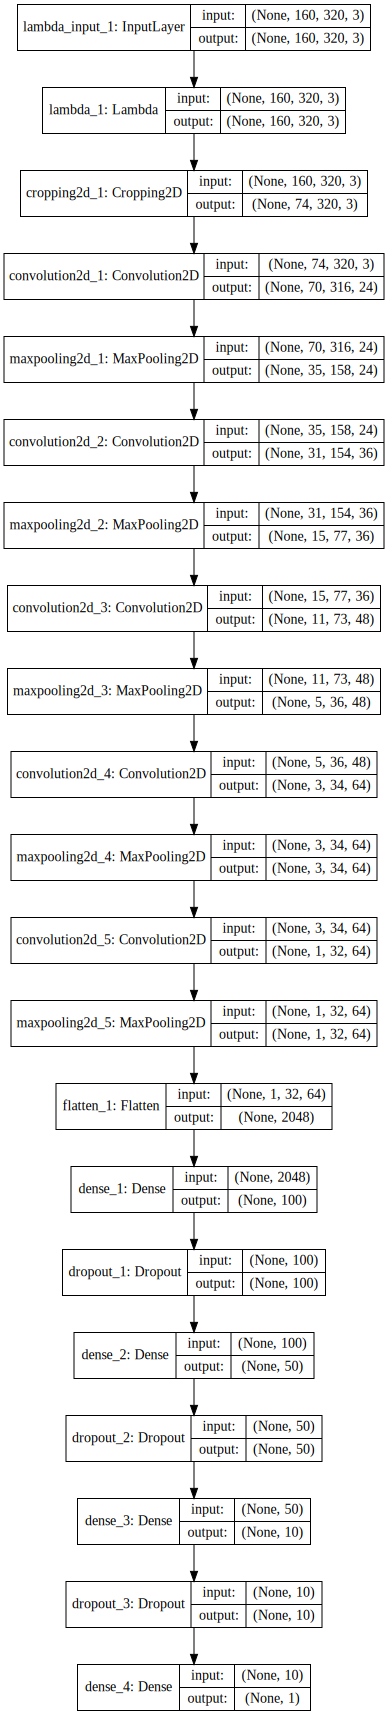

In [13]:
# visual display
figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

# Save the model as png file
plot(model, to_file='model.png', show_shapes=True)

In [14]:
model.compile(loss='mse',optimizer='adam')
_start_time = time.time()
history_object = model.fit(X_train, y_train, batch_size = BATCH_SIZE, validation_split=VALIDATION_SPLIT, shuffle=True, nb_epoch=EPOCHS)
print("Training time = {:.1f} seconds".format(time.time()-_start_time))
model.save(SAVED_FN)

Train on 23465 samples, validate on 7822 samples
Epoch 1/3
23465/23465 [==============================] - 29s - loss: 0.0059 - val_loss: 0.0097
Epoch 2/3
23465/23465 [==============================] - 27s - loss: 0.0038 - val_loss: 0.0075
Epoch 3/3
23465/23465 [==============================] - 27s - loss: 0.0032 - val_loss: 0.0064
Training time = 84.5 seconds


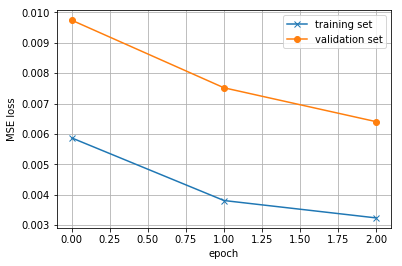

In [15]:
# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'],'-x')
plt.plot(history_object.history['val_loss'],'-o')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.grid()
plt.show()